# SNRateMetric
By Fabio Ragosta (fabio.ragosta@inaf.it)

Objective:
The estimate of the fraction of correctly classified SNe for different survey cadence.

Steps:

- Simulation of SN light curves from observed templates.
- Simulation of uniform distribution for SN explosion times, positions and redshits.
- Classification of simulated light curves by using PSNID.
- Estimation of the fraction of detected SNe as function of redshift. 
- Estimation of the fraction of classified SNe as function of redshift.

Stretch Goals

- Simulation of light curves from other transients.
- Estimation of the expected SN rate.

In [1]:
import sys, os, h5py, pickle, warnings, subprocess
sys.path.append('/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs') #path where to find the lsst util
from opsimUtils import *

from lsst.sims.maf.metrics import BaseMetric
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.utils import m52snr, radec2pix

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
from pylab import cm
import time
from itertools import groupby

os.environ['SNANA_DIR']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNANA'
os.environ['SNDATA_ROOT']='/home/idies/workspace/Storage/fragosta/persistent/LSST_OpSim/Scripts_NBs/SNRate_Simulations/SNDATA_ROOT'
os.environ['LSST_DIR']='./util_snrmetric'
%matplotlib inline

In [2]:
from SNclassification_metric import SNclassification_metric, template_lc, getDataMetric, generateSNPopSlicer 

In [3]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')

dbDir = '/home/idies/workspace/lsst_cadence/FBS_1.7/'
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRatev1.7'.format(your_username)

if not os.path.exists(os.path.abspath(outDir)):
    os.mkdir(os.path.abspath(outDir))

resultsDb = db.ResultsDb(outDir=outDir)

## Light curves from SN templates

We  simulate light curves at different redshifts appling the K-correction and taking into account the effect of the time dilation. 

List of the SN templates used for the simulation in Table 3 [Cappellaro et al. 2015](https://arxiv.org/pdf/1509.04496.pdf)

The dictionary for the tempates is defined by the SN type and subtypes. It is indicated the fraction of each subtype in each SN group .

In [4]:
sngroups ={'Ia':{'Ia':(['1990N','1992A','1994D','2002bo'],70),  
                    'IaBright':(['1991T','1999ee'],10), 
                    'IaFaint':(['1991bg'],15), 
                    'Iapec':(['2000cx','2002cx'],5)},
              'II':{'IIP':(['1999em','2004et','2009bw'],60),        # 60
                    'IIFaint':(['1999br','1999gi','2005cs'],10),    # 10
                    'IIL':(['1992H'],10),                           # 10
                    'IIb':(['1993J','2008ax'],10),                  # 10
                    'II87A':(['1987A'],10)},                        # 10
              'IIn':{'IIn':(['2010jl'],45),
                     'IIna':(['1998S'],45), 
                     'IIpec':(['1997cy','2005gj'],10)},
              'Ibc':{'Ib':(['2009jf','2008D'],27), 
                     'Ic':(['1994I','2004aw','2007gr'],68), 
                     'IcBL':(['1998bw'],5)}, 
              'SLSN' : {'SLSN':(['2008es'],100)}}

In [5]:
temp = template_lc(sn_group=sngroups ,
                               z_min=0.1,z_max= 0.9,z_step=0.1)
obs_template = temp.run()

I'm reading the templates


In [6]:
obs_template['magobs'].keys()

dict_keys(['1990N', '1992A', '1994D', '2002bo', '1991T', '1999ee', '1991bg', '2000cx', '2002cx', '1999em', '2004et', '2009bw', '1999br', '1999gi', '2005cs', '1992H', '1993J', '2008ax', '1987A', '2010jl', '1998S', '1997cy', '2005gj', '2009jf', '2008D', '1994I', '2004aw', '2007gr', '1998bw', '2008es'])

Here a plot of the simulated light curves:

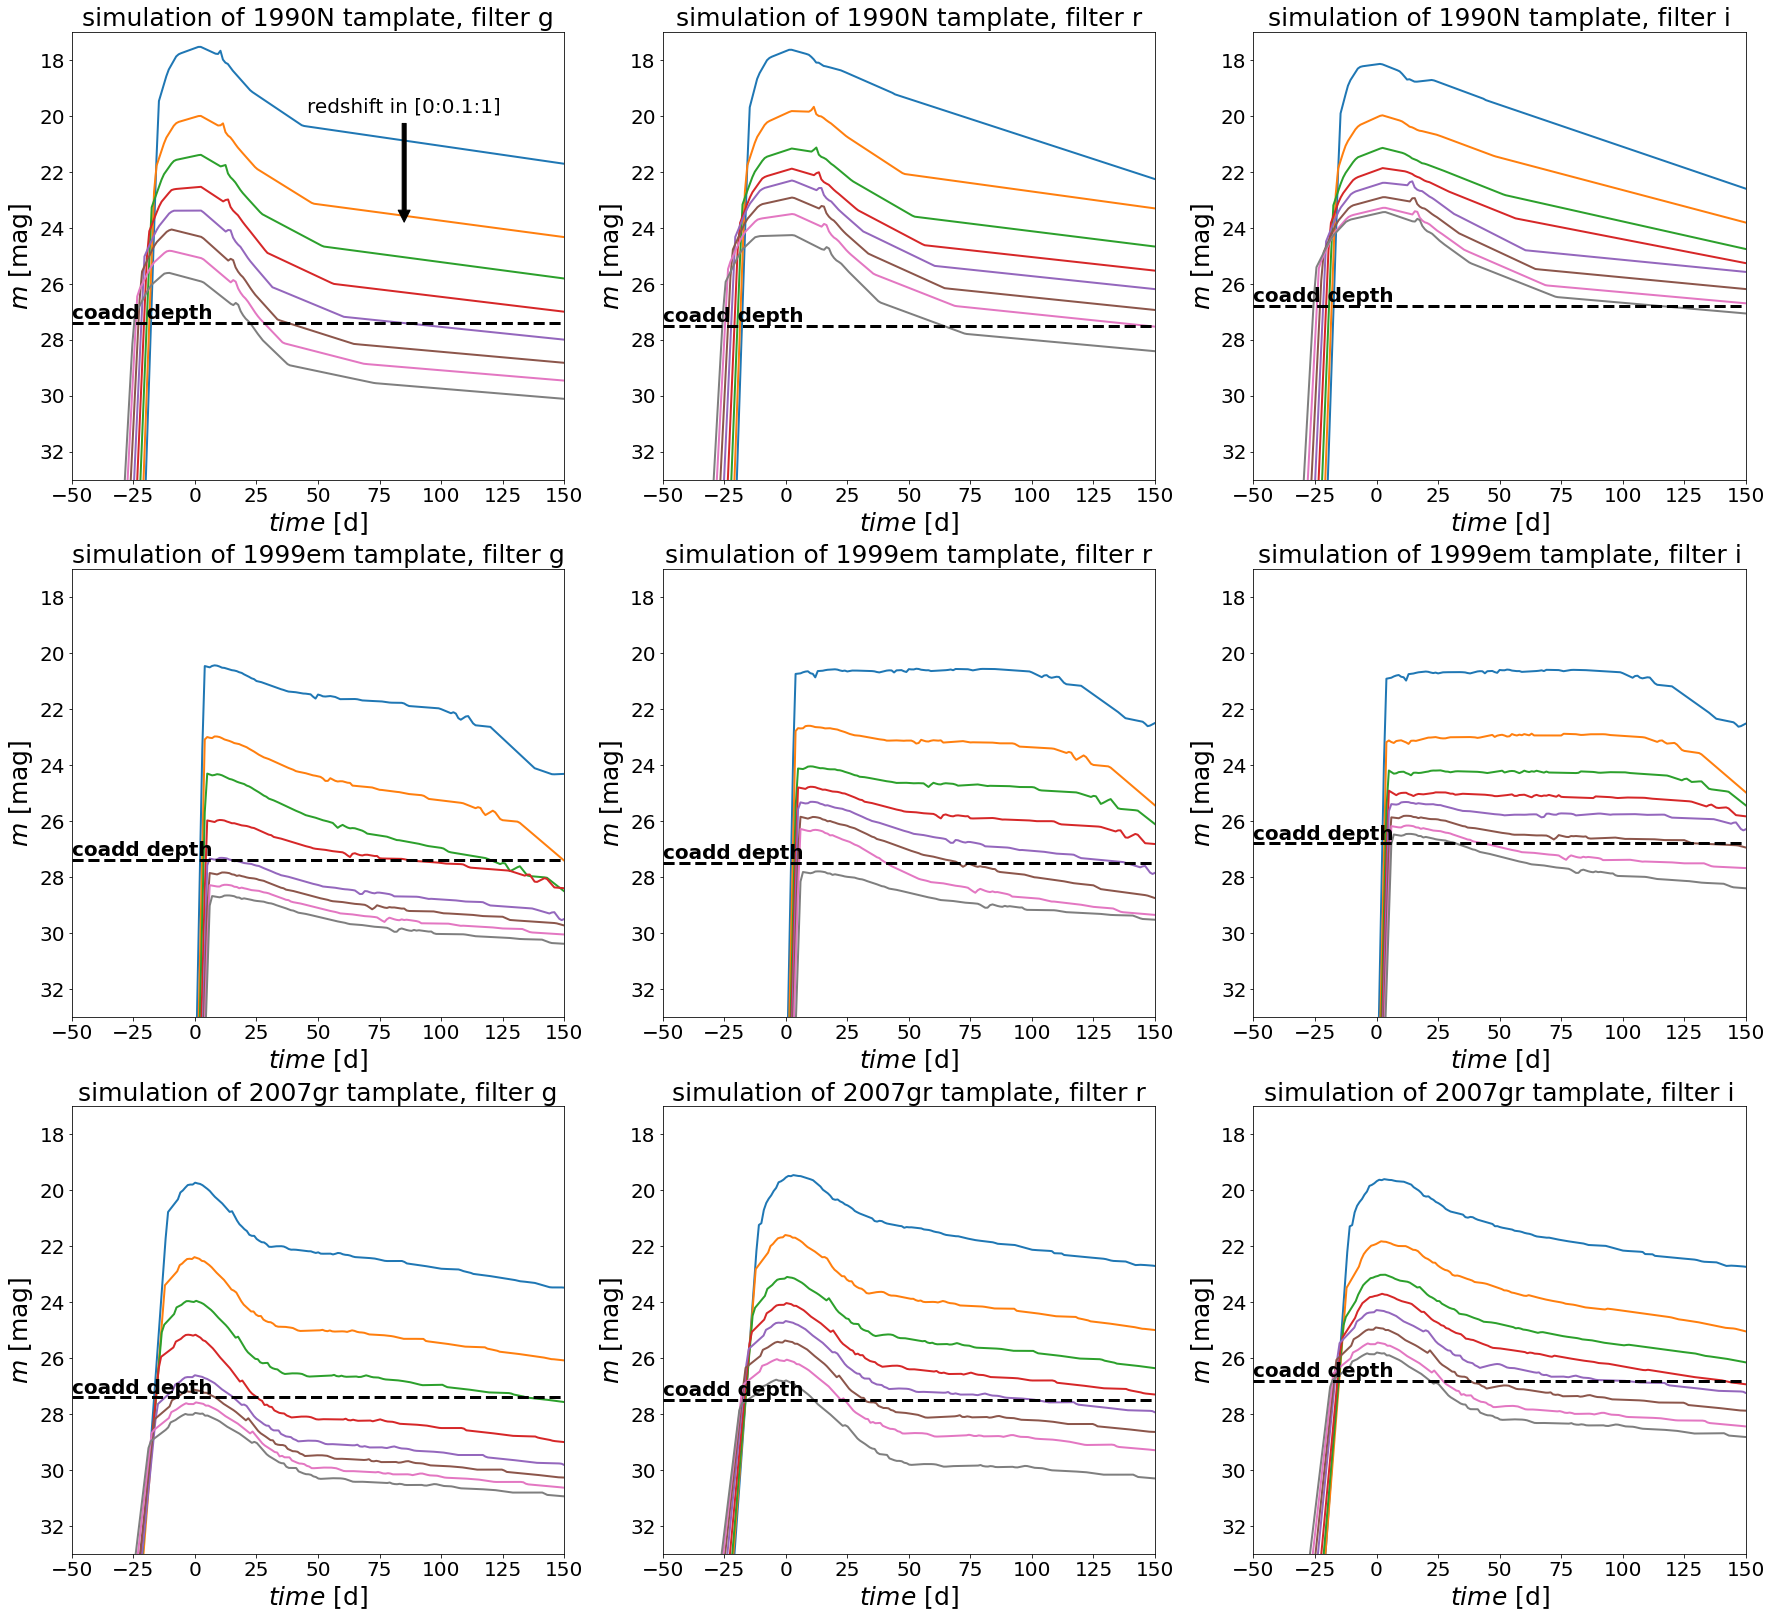

In [7]:
fig, axs = plt.subplots(3,3,figsize=(30,28))
for i, t in enumerate(['1990N','1999em','2007gr']):
    for j, f in enumerate(['g','r','i']):
        for z in obs_template['phobs'][t].keys():
            mag =obs_template['magobs'][t][z][f]
            ph = obs_template['phobs'][t][z][f]
            axs[i,j].plot(ph, mag,'-',lw=2)
        axs[i,j].invert_yaxis()
        if i==0 and j==0:
            axs[i,j].annotate('redshift in [0:0.1:1]',xy=(85, 24),xycoords='data',xytext=(85, 20), textcoords='data',fontsize=20,
                arrowprops=dict(facecolor='black', shrink=0.05),horizontalalignment='center', verticalalignment='bottom')
        axs[i,j].set_ylim([33,17])
        axs[i,j].set_xlim([-50,150])
        axs[i,j].set_xlabel(r'$time$ [d]',fontsize=25)
        axs[i,j].set_ylabel(r'$m$ [mag]',fontsize=25)
        axs[i,j].set_title(r'simulation of {} tamplate, filter {}'.format(t,f),fontsize=25)
        axs[i,j].tick_params('both', labelsize=20)
        if f == 'g':
            px,py = [-50,150],[27.4,27.4]
        elif f =='r':
            px,py=[-50,150],[27.5,27.5]
        elif f=='i':
            px,py = [-50,150],[26.8,26.8]
        axs[i,j].plot(px,py, 'k--', lw=3)
        axs[i,j].annotate('coadd depth',xy=(px[0],py[0]),xycoords='data',fontsize=20, weight='bold',
               horizontalalignment='left', verticalalignment='bottom')

### Explosion times
We set an array of explosion epochs that space uniformly the year of survey. 

In [7]:
expl_range=np.arange(0,365,10)
expl_range.size

37

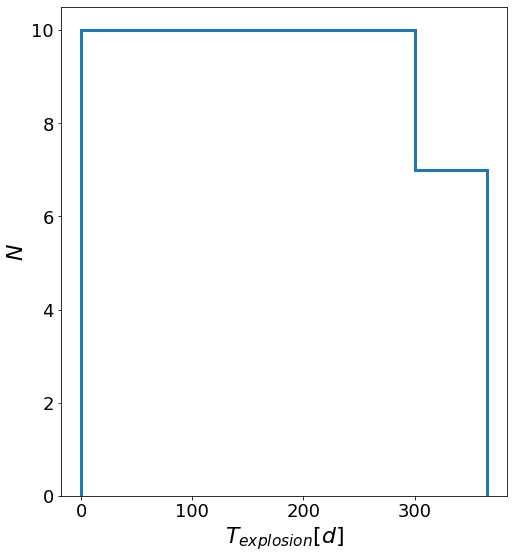

In [8]:
fig, ax=plt.subplots(1,figsize=(8,9))
ax.hist(expl_range, np.array([0,100,200,300,365]),histtype='step',linewidth=3,align='mid',label='Type Ia')
ax.set_xlabel(r'$T_{explosion}[d]$',fontsize=22)
ax.set_ylabel(r'$N$',fontsize=22)
ax.tick_params('both', labelsize=18)

### Extraction of the observation for the simulated SNe 

Once we have associated an explosion epoch to the SNe, we obtain the magnitude values at the LSST observation epochs. 

In [9]:
import glob

workpath = os.getcwd()
os.chdir(dbDir)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
#workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns/timeGaps/'
os.chdir(workpath) # change back to work directory
dblist_all.sort()

In [10]:
dblist_all[0]

'baseline_nexp1_v1.7_10yrs.db'

In [11]:
surveyDuration = 1 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )

In [12]:
dbname = dblist_all[0]
opsdb = db.OpsimDatabase(dbDir+dbname)
coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])}
slicer = slicers.UserPointsSlicer(coo['ra'], coo['dec'], latLonDeg=True, badval=0)
metric = getDataMetric(colname=['night', 'observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter','visitExposureTime','visitTime'])
# bundle
Sky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)

# group bundle
bundleDict = {'Sky':Sky}
group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)

# run
group.runAll()

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  for columns ['fiveSigmaDepth', 'fieldRA', 'visitExposureTime', 'night', 'filter', 'fieldDec', 'visitTime', 'observationStartMJD']
Found 108958 visits
Running:  ['Sky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [13]:
data = Sky.metricValues.data

# create DataFrame from ndarrays
df = pd.concat( [pd.DataFrame(d) for d in data], ignore_index=True, )

In [14]:
df

,fiveSigmaDepth,fieldRA,visitExposureTime,night,filter,fieldDec,visitTime,observationStartMJD
0,22.941185,150.553481,30.0,496,i,1.841210,31.0,60349.167977
1,24.281264,150.353768,30.0,500,r,1.549694,31.0,60353.140882
2,23.886002,150.353768,30.0,500,i,1.549694,31.0,60353.155836
3,24.783559,150.353768,30.0,500,g,1.549694,31.0,60353.149123
4,24.782320,150.353768,30.0,500,g,1.549694,31.0,60353.148741
...,...,...,...,...,...,...,...,...
964,23.901815,148.934110,30.0,578,r,2.707926,31.0,60430.972247
965,24.016817,149.793707,30.0,471,r,2.770087,31.0,60324.325048
966,23.397885,149.605657,30.0,474,i,3.108690,31.0,60327.253010
967,24.265359,148.923962,30.0,498,g,2.849829,31.0,60351.194528


To properly coadd the visits in the same night we operate some edits on the dataframe:

In [15]:
keygroup = ['filter', 'night']

df.sort_values(by=keygroup, ascending=[
                 True, True], inplace=True)

coadd_df = df.groupby(keygroup).agg({'visitExposureTime': ['sum'],
                                       'visitTime': ['sum'],
                                       'observationStartMJD': ['mean'],
                                       'fieldRA': ['mean'],
                                       'fieldDec': ['mean'],
                                       'fiveSigmaDepth': ['mean']}).reset_index()

coadd_df.columns = ['filter','night', 'visitExposureTime','visitTime',
                    'observationStartMJD', 'fieldRA', 'fieldDec',
                    'fiveSigmaDepth']

coadd_df.loc[:, 'fiveSigmaDepth'] += 1.25 * \
    np.log10(coadd_df['visitTime']/30.)

coadd_df.sort_values(by=['filter', 'night'], ascending=[
                     True, True], inplace=True)

In [16]:
coadd_df

,filter,night,visitExposureTime,visitTime,observationStartMJD,fieldRA,fieldDec,fiveSigmaDepth
0,g,441,300.0,310.0,60294.289211,150.158401,2.059202,25.762180
1,g,443,300.0,310.0,60296.285020,149.724031,2.308126,25.785715
2,g,447,300.0,310.0,60300.297483,149.544441,2.262656,25.709575
3,g,463,300.0,310.0,60316.232758,150.199818,1.721362,25.383625
4,g,465,300.0,310.0,60318.250140,150.243737,1.791352,25.493167
...,...,...,...,...,...,...,...,...
72,r,551,30.0,31.0,60404.086588,149.013981,0.930121,24.416018
73,r,575,600.0,620.0,60427.985375,149.633408,2.412413,25.438865
74,r,578,30.0,31.0,60430.972247,148.934110,2.707926,23.919616
75,r,589,30.0,31.0,60441.982932,150.597305,3.807746,23.976285


We create a mask to check if there is any observation during the transient duration. We show an example fixing a template (here 1991T) a redshift (here z =0.1) and an explosion time.

In [42]:
lc= pd.DataFrame(obs_template['phobs']['1991T'][0.5])
obs = coadd_df['observationStartMJD']
times = expl_range[4] + coadd_df['observationStartMJD'].min()
transDuration = np.ptp(lc)
indexlc = np.where((obs>= times) & (obs<=times+transDuration))[0]
np.array(obs[indexlc])

array([60349.16030895, 60350.25864119, 60351.15633956, 60353.15416117,
       60355.21947842, 60356.14907781, 60372.09955105, 60373.17806751,
       60382.13711297, 60386.14862713, 60399.01264423, 60427.99246957,
       60457.98177114, 60341.27197852, 60349.1722599 , 60351.14542583,
       60353.15602711, 60356.14823796, 60369.12312205, 60371.13453247,
       60372.10664596, 60396.01593645, 60398.0873925 , 60399.01973914,
       60402.08141953, 60427.99956448, 60457.98886604, 60349.1579902 ,
       60351.15961565, 60353.14569622, 60356.15617272, 60372.09245614,
       60373.16174366, 60386.16477645, 60399.00554933, 60402.06528709,
       60404.08658793, 60427.98537466, 60430.9722474 , 60441.98293186,
       60457.97467623])

In [18]:
transDuration

281.0

We select the epochs of the lightcurve for which we have LSST observation, then we interpolate the magnitudes at these epochs.

In [40]:
snclass=SNclassification_metric(LCfolder='./LC_baseline_nexp1_v1.7_10yrs')
snclass.read_lightCurve('./template/snlc_1991T_z=0.1_temp.ascii')

In [43]:
lcEpoch = (obs[indexlc] - times)
sim_lc = SNclassification_metric.make_lightCurve(snclass,lcEpoch, coadd_df['filter'][indexlc])

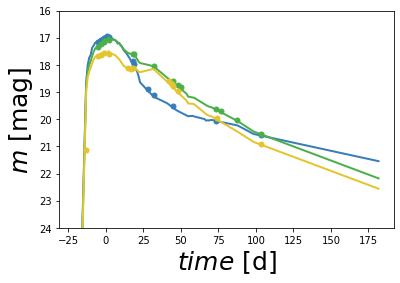

In [32]:
plt.figure()
for i, (f , c) in enumerate(zip(['g','r','i'],['#377eb8','#4daf4a', '#e3c530'])):    
    filter_match = np.where(coadd_df['filter'][indexlc]==f)
    mag = obs_template['magobs']['1991T'][0.1][f]
    ph = obs_template['phobs']['1991T'][0.1][f]
    idx_plot= np.where(np.array(lcEpoch)[filter_match]<transDuration)
    plt.plot(ph, mag,'-',lw=2, color=c)
    plt.plot(np.array(lcEpoch)[filter_match][idx_plot]-20,sim_lc[filter_match][idx_plot],'o',markersize=5, color =c)
    plt.gca().invert_yaxis()
    plt.ylim([24,16])
    plt.xlabel(r'$time$ [d]',fontsize=25)
    plt.ylabel(r'$m$ [mag]',fontsize=25)
    

### Selection criteria for the detection and classification

We consider two different labels for the SN: detected and classifiable (labeled as filtered_class).

- detected: if the number of detections on the lightcurve in all filters is higher than 3;
- filtered_class: if the number of detections on the lightcurve in all filters, whitin 30 days from the explosion, is higher than 5;

We produce a file to inject in PSNID for the classification only for those who pass the classification threshold. 

We estimate the SNR from the five sigma depth for the observation epochs.

In [44]:
lcSNR = m52snr(sim_lc, coadd_df['fiveSigmaDepth'][indexlc])
lcSNR

11     7672.747475
12     4533.768482
13    11812.473664
14    21801.678281
15     3958.163264
16    12780.119741
17     8501.066834
18     1668.298803
19      809.254218
20      718.434019
21      976.638910
22      949.570557
23      376.810425
37       14.228198
38     3339.841969
39     4179.674533
40     7415.589512
41     4933.304936
42      431.650501
43      876.033606
44     3700.094459
45      274.668312
46      350.435490
47     1373.708242
48      468.981423
49      525.036955
50      197.747941
63     6771.213693
64     9959.283329
65    16300.515029
66    12849.174555
67     8105.165257
68     2169.026358
69     1230.098356
70     3260.578873
71      959.534802
72      867.466968
73     1061.593067
74      241.885977
75      189.912960
76      402.759920
Name: fiveSigmaDepth, dtype: float64

Finally we compare these values with respect the threshold we set for the detection (SNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5})

In [24]:
detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}
lcpoints_AboveThresh = np.zeros(len(lcSNR), dtype=bool) 
for f in ['g','r','i']:                    
        filtermatch = np.where(coadd_df['filter'][indexlc] == f)
        lcpoints_AboveThresh[filtermatch] = np.where(np.array(lcSNR)[filtermatch] >= detectSNR[f],True,False) 

In [25]:
lcpoints_AboveThresh

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

## SN classification with PSNID

It is worth to note that PSNID classify light curves as 'Ia','Ibc','II','UNKNOWN', we considered 'UKNOWN' as the light curve is unclassified. The confusion matrix is normalized with respect to the the number of classifiable SNe.

We finally save the classification results and build a confusion matrix.

In [35]:
r = subprocess.check_output([os.environ['SNANA_DIR']+'/bin/psnid.exe', os.environ['LSST_DIR']+'/PSNID_LSST__baseline_nexp1_v1.7_10yrs.nml'], stderr=subprocess.STDOUT)
                                
# we search for classification flags in the variable r 
Ia=['1990N','1992A','1994D','2002bo','1991T','1999ee','1991bg','2000cx','2002cx']
Ibc=['2009jf','2008D','1994I','2004aw','2007gr','1998bw']
II=['1999em','2004et','2009bw','1999br','1999gi','2005cs','1992H','1993J','2008ax',
    '1987A','2010jl','1998S','1997cy','2005gj','2008es']
line= np.array(r.split())
custom_split = np.vectorize(self.custom_split)
types = np.where(line==b'type')
z_ = np.where(line==b'z_prior')
sn_t = custom_split(x=line[z_[0]-1],c='_',index=0)
z_t = custom_split(x=line[z_[0]-1],c='_',index=1)
float_z = np.vectorize(float)
z_t = float_z(z_t)
z = np.unique(z_t)

# confusion matrix
for zz in z:
    CM[zz]['Ia']['Ia']=0
    CM[zz]['Ibc']['Ia']=0
    CM[zz]['II']['Ia']=0
    CM[zz]['UKNOWN']['Ia']=0
    CM[zz]['Ia']['Ibc']=0
    CM[zz]['Ibc']['Ibc']=0
    CM[zz]['II']['Ibc']=0
    CM[zz]['UKNOWN']['Ibc']=0
    CM[zz]['Ia']['II']=0
    CM[zz]['Ibc']['II']=0
    CM[zz]['II']['II']=0
    CM[zz]['UKNOWN']['II']=0
    z_index = np.in1d(z_t,[zz])
    type_z= line[types[0]+2][z_index]
    sn_Ia= np.in1d(sn_t,Ia)[z_index]
    sn_Ibc= np.in1d(sn_t,Ibc)[z_index]
    sn_II= np.in1d(sn_t,II)[z_index]
    CM[zz]['Ia']['Ia']+=np.nansum(type_z[sn_Ia]==b'Ia')/(np.nansum(sn_Ia))
    CM[zz]['Ibc']['Ia']+=np.nansum(type_z[sn_Ia]==b'Ibc')/(np.nansum(sn_Ia))
    CM[zz]['II']['Ia']+=np.nansum(type_z[sn_Ia]==b'II')/(np.nansum(sn_Ia))
    CM[zz]['UKNOWN']['Ia']+=np.nansum(type_z[sn_Ia]==b'UNKNOWN')/(np.nansum(sn_Ia))
    CM[zz]['Ia']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'Ia')/(np.nansum(sn_Ibc))
    CM[zz]['Ibc']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'Ibc')/(np.nansum(sn_Ibc))
    CM[zz]['II']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'II')/(np.nansum(sn_Ibc))
    CM[zz]['UKNOWN']['Ibc']+=np.nansum(type_z[sn_Ibc]==b'UNKNOWN')/(np.nansum(sn_Ibc))
    CM[zz]['Ia']['II']+=np.nansum(type_z[sn_II]==b'Ia')/(np.nansum(sn_II))
    CM[zz]['Ibc']['II']+=np.nansum(type_z[sn_II]==b'Ibc')/(np.nansum(sn_II))
    CM[zz]['II']['II']+=np.nansum(type_z[sn_II]==b'II')/(np.nansum(sn_II))
    CM[zz]['UKNOWN']['II']+=np.nansum(type_z[sn_II]==b'UNKNOWN')/(np.nansum(sn_II))
    CM[zz]=CM[zz].fillna(0)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in long_scalars
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipyk

In [36]:
[[print('z= '+str(k)),print(CM[k])] for k in CM.keys()] 
                

z= 0.1
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0
z= 0.4
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0
z= 0.7
      Ia  Ibc   II  UKNOWN
Ia   1.0  0.0  0.0     0.0
Ibc  0.0  0.0  0.0     0.0
II   0.0  0.0  0.0     0.0


[[None, None], [None, None], [None, None]]

### Example of the metric using the MAF


The algorithm is repeated for all the positions where the SNe has been simulated.

Here, as an example, we simulate two types of SNe that explode in 37 different epochs within 1 year in the COSMOS filed (RA= 149.72403071; DEC=2.30812595) for z= 0.1,0.5,0.9 .

In [20]:
surveyDuration = 1 
init = 1 
sqlconstraint = '( filter= "g" or  filter = "r" or filter="i")'
sqlconstraint+='and night>{} and night < {} '.format(init*365.25,(init+surveyDuration)*365.25 )

Parameters:

- templates: dictionary with names of the type, subtype, the transient and fraction of the transient-like object in the given subclass;

- t_start, t_end: the limits of the epoch range where to drawn the explosion times;

- n_event :  the number of events to simulate;

- zmin, zmax, zstep: the limits and the step of the redshift range;

- coo: dictionary of ra and dec, if None an array of n_event with random ra, dec is created.

The coordinates are used in the UserPointsSlicer to set LSST observations' coordinates.

In [21]:
sngroups ={'Ia':{'Ia':(['1991T'],100)},'II':{'II':(['2004et'],100)}}
slicer = generateSNPopSlicer(templates= sngroups, t_start=0, 
                             t_end=365, t_step=10, n_events=37, seed=42, zmin=0.1, zmax=1,zstep=0.4,
                             coo={'ra':np.array([149.72403071]),'dec':np.array([2.30812595])})
print('z_range = {}'.format(slicer.slicePoints['zrange']))
print('explosion epochs = {}'.format(np.sort(slicer.slicePoints['explosion_times'])))

I'm reading the templates
z_range = [0.1 0.5 0.9]
explosion epochs = [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360]


In [22]:
metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_parallel_v1.7'.format(your_username)
opSimDbs, resultDbs = connect_dbs(dbDir, metricDataPath)
process = []
import multiprocessing as mp
start_time = time.time()
for run in ['baseline_nexp1_v1.7_10yrs']:
    metriclc = SNclassification_metric(metricName='test',LCfolder='./LC_{}'.format(run), mjdCol='observationStartMJD',\
                 m5Col='fiveSigmaDepth', filterCol='filter', RACol='fieldRA', DecCol='fieldDec',\
                              surveyDuration=surveyDuration,\
                              detectSNR={'u': 5, 'g': 5, 'r': 5, 'i': 5, 'z': 5, 'y': 5}, \
                              ndetect=3,nclass=5,dataout=True)
    metriclc_trans= metricBundles.MetricBundle(metriclc, slicer, sqlconstraint)
    bundleDict={'test':metriclc_trans}

    warnings.filterwarnings('ignore')
    metriclc_trans.setRunName(run)
    bgrouplc = metricBundles.MetricBundleGroup(bundleDict, opSimDbs[run], metricDataPath, resultDbs[run])
    p=mp.Process(target=bgrouplc.runAll)
    p.start()
    process.append(p)
for pr in process:
    pr.join()    
print("--- {:.2f} minutes ---\n".format((float(time.time()) - float(start_time))/60))
print('####################\n')

Querying database SummaryAllProps with constraint ( filter= "g" or  filter = "r" or filter="i")and night>365.25 and night < 730.5  for columns ['fiveSigmaDepth', 'fieldRA', 'visitExposureTime', 'night', 'filter', 'fieldDec', 'visitTime', 'observationStartMJD']
Found 108958 visits
Running:  ['test']
['./template/snlc_1991T_z=0.1_temp.ascii', '1991T', '0.1']
['./template/snlc_2004et_z=0.1_temp.ascii', '2004et', '0.1']
['./template/snlc_1991T_z=0.5_temp.ascii', '1991T', '0.5']
['./template/snlc_2004et_z=0.5_temp.ascii', '2004et', '0.5']
['./template/snlc_1991T_z=0.9_temp.ascii', '1991T', '0.9']
['./template/snlc_2004et_z=0.9_temp.ascii', '2004et', '0.9']
________________________________________
total SNe simulated: 222; lost SNe: 20
z= 0.1 type=Ia
Detected=16 UnDetected=1 filtered_class=11 not_filtered_class=5 classified=6 unclassified=5
           Ia  Ibc        II    UKNOWN
Ia   0.428571  0.0  0.000000  0.571429
Ibc  0.000000  0.0  0.000000  0.000000
II   0.000000  0.0  0.266667  0.7333

The parameter 'lost' stands for the SNe that do not fall in the LSST observation epochs range.

In [23]:

metricDataPath = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/SNRate_parallel_v1.7'.format(your_username)
resultDbs = getResultsDbs(metricDataPath)
# the following line will be useful if you did not run MAF on all 75 opsims
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in ['baseline_nexp1_v1.7_10yrs']:#,dbRuns[29]]:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, metricDataPath)

Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=8, approximate resolution 439.742261 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [24]:
df17={}
coo_df={}
for opsim in  ['baseline_nexp1_v1.7_10yrs']:#,'baseline_nexp2_v1.7_10yrs']:
    df17[opsim]={}
    coo_df[opsim]={}
    
    bmetric =[(5, '_baseline_nexp1_v1.7_10yrs'), (3, 'get_Col')]
    for metric in bmetric:
        coo_df[opsim][metric[1]] = np.column_stack((bundleDicts[opsim][metric].slicer.slicePoints['ra'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]
                                          ,bundleDicts[opsim][metric].slicer.slicePoints['dec'][np.where(bundleDicts[opsim][metric].metricValues.mask==False)]))
        arr=bundleDicts[opsim][metric].metricValues.data
        arr_=arr[np.where(arr!=None)]
        df17[opsim][metric[1]] = pd.DataFrame.from_records(arr_)

## Observed light curve from the simulation

In [25]:
lc_list = glob.glob('LC_baseline_nexp1_v1.7_10yrs/*dat')
lc_list[0:10]
obs={l:{}for l in lc_list}
coo = {l:[]for l in lc_list}
expl = []
for lobs in obs.keys():
    expl.append(float(lobs.split('_')[-2]))
    f= open(lobs,'r')
    r= f.read()
    l =r.split('\n')
    idx_z = np.where(np.array(l)=='REDSHIFT_FINAL:  0.1 +- 0.700 (CMB)')
    loc = l[3].split()
    ra = float(loc[1])
    loc = l[4].split()
    dec = float(loc[1])
    coo[lobs].append([ra,dec])    
    z=float(np.array(r.split('\n'))[6].split()[1])
    idx_in = np.where(np.array(l)=='VARLIST:  MJD  FLT FIELD   FLUXCAL   FLUXCALERR   SNR    MAG     MAGERR ')
    idx_end= np.where(np.array(l)=='END: ')
    e_obs,m_obs,err_obs,f_obs=[],[],[],[]
    for i in np.arange(idx_in[0][0]+1,idx_end[0][0],1):
        e_obs.append(float(l[i].split()[1]))
        m_obs.append(float(l[i].split()[-2]))
        err_obs.append(float(l[i].split()[-1]))
        f_obs.append(l[i].split()[2])
    obs[lobs].update({z:{'epoch':np.array(e_obs),
                      'mag':np.array(m_obs),
                      'mag_err':np.array(err_obs),'filter':np.array(f_obs),'coo': [ra,dec]}})
    

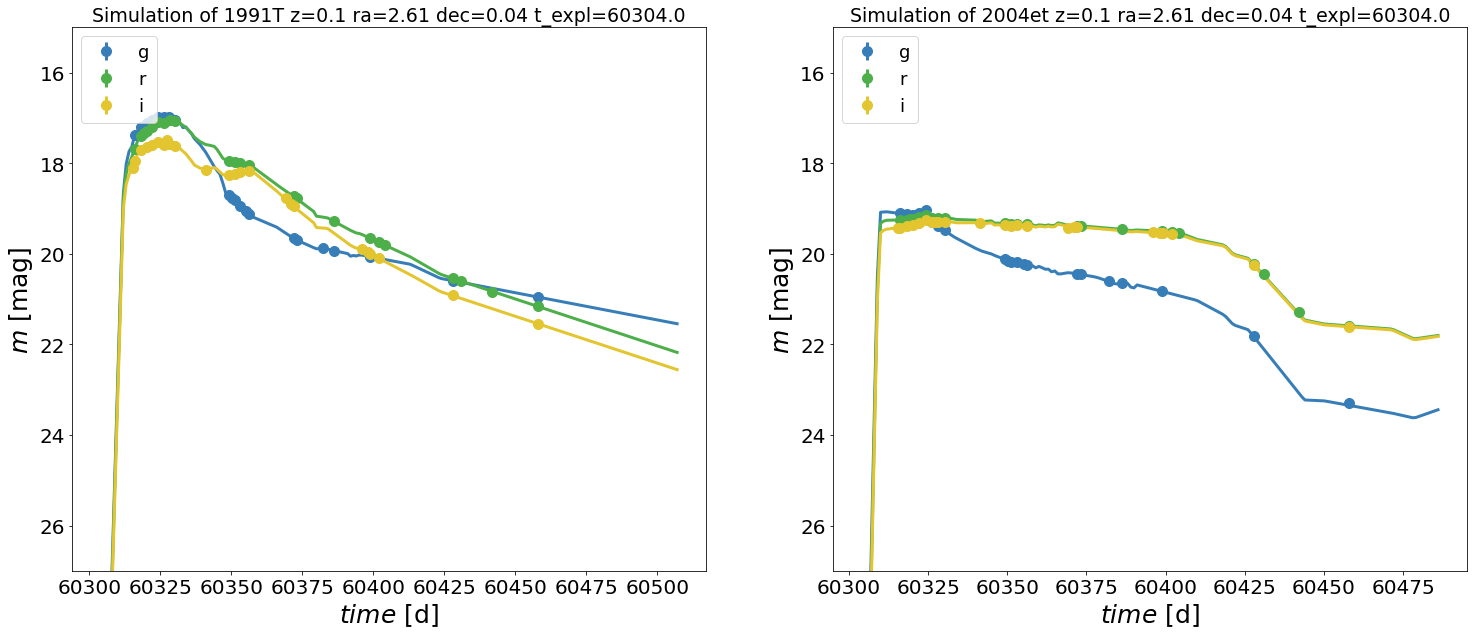

In [36]:
ObsStart= df17['baseline_nexp1_v1.7_10yrs']['get_Col']['observationStartMJD'][1].min()
color = ['#377eb8','#4daf4a', '#e3c530']
ty=['1991T','2004et']
llist=['LC_baseline_nexp1_v1.7_10yrs/LSST_1991T_0.1_60304.28.dat',
 'LC_baseline_nexp1_v1.7_10yrs/LSST_2004et_0.1_60304.28.dat']
fig, axes = plt.subplots(1,2,figsize=(25,10))
for i,axs in enumerate(axes.flatten()[0:3]):
    for j, f in enumerate(['g','r','i']):
        c=color[j]
        t_expl = float(llist[i].split('_')[-1].split('.')[0])
        z = float(llist[i].split('_')[-2])
        filters=obs[llist[i]][z]['filter']==f
        mag =obs_template['magobs'][ty[i]][z][f]
        maglc =obs[llist[i]][z]['mag'][filters]
        magerrlc =obs[llist[i]][z]['mag_err'][filters]
        
        if np.size(obs[llist[i]][z]['epoch'][filters])>0:
            ph = obs_template['phobs'][ty[i]][z][f]+t_expl-obs_template['phobs'][ty[i]][z][f][0]
            phlc = obs[llist[i]][z]['epoch'][filters]#-obs[llist[i]][z]['epoch'][filters][0]+e[i]
            axs.errorbar(phlc, maglc,yerr=3*magerrlc,fmt='o',elinewidth=3,color=c,markersize=10,label=f)
            axs.plot(ph, mag,'-',lw=3,color=c)
        axs.invert_yaxis()
        axs.set_ylim([27,15])
        #axs.set_xlim([60200,60400])
        axs.set_xlabel(r'$time$ [d]',fontsize=25)
        axs.set_ylabel(r'$m$ [mag]',fontsize=25)
        axs.set_title(r'Simulation of {} z={} ra={} dec={} t_expl={}'.format(ty[i],z,
        np.round(obs[llist[i]][z]['coo'][0],2),np.round(obs[llist[i]][z]['coo'][1],2), t_expl),fontsize=19)
        axs.tick_params('both', labelsize=20)
    #if i ==0:
        axs.legend(loc=2,fontsize=18)
plt.savefig('./lc_example.pdf')

## Skymap for detected and classified SNe

In the following some analysis that can be done on the output data.

In [7]:
fractions={'Ia':None,'II':None,'Ibc':None}

for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        o=[]
        
        for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):
            
            o.append(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['ConfusionMetric'][i][k][key][key])
            
        
        c+=np.array(o)
        
    fractions[key]=c/slicer.slicePoints['zrange'].size

In [17]:
detected = []

for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'])):

    det=0
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        det+=df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']/(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected']+
        df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['UnDetected'])

    detected.append(det/slicer.slicePoints['zrange'].size)
detected = pd.DataFrame(detected)

In [9]:
zfractions={'Ia':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'II':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index},
            'Ibc':{z:None for z in df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index}}
for j, key in enumerate(fractions.keys()):
    c = np.zeros(np.size(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class']))
    for l,k in enumerate(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][0].index):
        for i in range(len(c)):
            #for i in range(len(df17['baseline_nexp1_v1.7_10yrs']['Ia_DDF']['class'])):
            dd_filt = pd.DataFrame(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nFiltered']['filtered_class'])
            dd_det = pd.DataFrame(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['Detected'])
            dd_und = pd.DataFrame(df17['baseline_nexp1_v1.7_10yrs']['_baseline_nexp1_v1.7_10yrs']['class'][i].iloc[l]['nDet']['UnDetected'])
            c[i]=(dd_filt['filtered_class'].iloc[j]/(dd_det['Detected'].iloc[j]+dd_und['UnDetected'].iloc[j]))
        zfractions[key][k]=np.array(c)

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


In [10]:
from util_snrmetric.util_snratemetric import plt_mlw

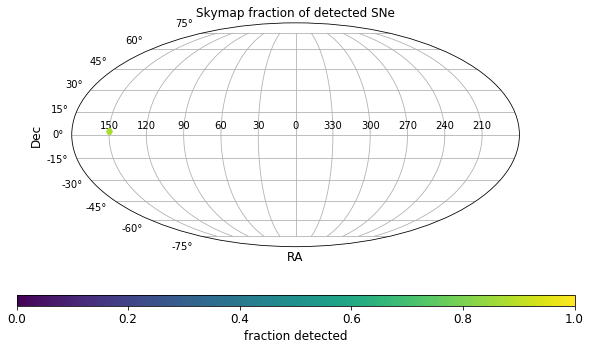

In [25]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,np.degrees(slicer.slicePoints['ra']),np.degrees(slicer.slicePoints['dec']),c=np.array(detected['Ia']),vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction detected','colormap':'viridis','title': 'Skymap fraction of detected SNe','psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')

The skymap for the classification is estimated as $\frac{(\text{number of filtered SNe for the classification})}{(\text{number of simulated SNe})}$$\times \frac{(\text{number of correctly classified SNe})}{(\text{number of filtered SNe for the classification})}$    

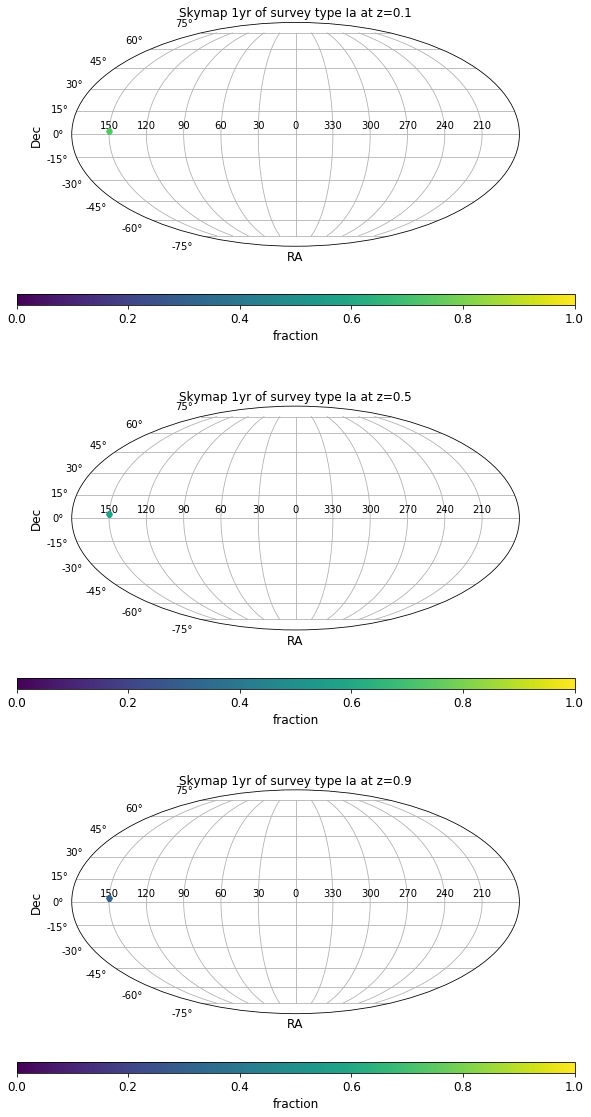

In [30]:
fig=plt.figure(figsize=(10,20))
for i, key in enumerate(['Ia']):
    for j, z in enumerate([0.1,0.5,0.9]):
        ax= fig.add_subplot(3,1,j+1, projection='mollweide')
        plt_mlw(ax,np.degrees(slicer.slicePoints['ra']),np.degrees(slicer.slicePoints['dec']),c=zfractions[key][z],vmin=0,vmax=1,dicts={'marker':'H','cbartitle':'fraction','colormap':'viridis','title': 'Skymap of classified SNe type {} at z={}'.format(key,z),'psize':50})
#plt.savefig('./Figure/skymap_fraction.pdf')